<a href="https://colab.research.google.com/github/tg-bomze/collection-of-notebooks/blob/master/High_Resolution_Daytime_Translation_(RUS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><font color="black" size="+4">Быстрая смена времени суток</font></b>

<b><font color="black" size="+2">Основан на:</font></b>

**GitHub репозитории**: [HiDT](https://github.com/saic-mdal/HiDT)

**Статья**: [High-Resolution Daytime Translation Without Domain Labels](https://arxiv.org/abs/2003.08791)

**Авторы**: Anokhin Ivan, Solovev Pavel, Korzhenkov Denis, Kharlamov Alexey, Khakhulin Taras, Silvestrov Alexey, Nikolenko Sergey, Lempitsky Victor, Sterkin Gleb

<b><font color="black" size="+2">Colab собрал:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@bomze](https://t.me/bomze),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

```
Чтобы начать, нажмите на кнопку (куда указывает красная стрелка), после чего дождитесь завершения выполнения блока.
```


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Устанавливаем все необходимые компоненты</font></b>

%cd /content
!rm -rf sample_data
!rm -rf HiDT
!git clone https://github.com/saic-mdal/HiDT.git

import argparse
import glob
import os
import sys
sys.path.append('./HiDT')

import torch
from PIL import Image
from torchvision import transforms
from IPython.display import clear_output
from google.colab import files
from tqdm import tqdm

from hidt.networks.enhancement.RRDBNet_arch import RRDBNet
from hidt.style_transformer import StyleTransformer
from hidt.utils.preprocessing import GridCrop, enhancement_preprocessing

config_path = './HiDT/configs/daytime.yaml'
gen_weights_path = './HiDT/trained_models/generator/daytime.pt'
inference_size = 256  # the network has been trained to do inference in 256px, any higher value might lead to artifacts
device = 'cuda:0'
styles_path = './HiDT/styles.txt'
enhancer_weights = './HiDT/trained_models/enhancer/enhancer.pth'

style_transformer = StyleTransformer(config_path,
                                     gen_weights_path,
                                     inference_size=inference_size,
                                     device=device)
with open(styles_path) as f:
    styles = f.read()
styles = {style.split(',')[0]: torch.tensor([float(el) for el in style.split(',')[1][1:-1].split(' ')]) for style in styles.split('\n')[:-1]}
crop_transform = GridCrop(4, 1, hires_size=inference_size * 4)

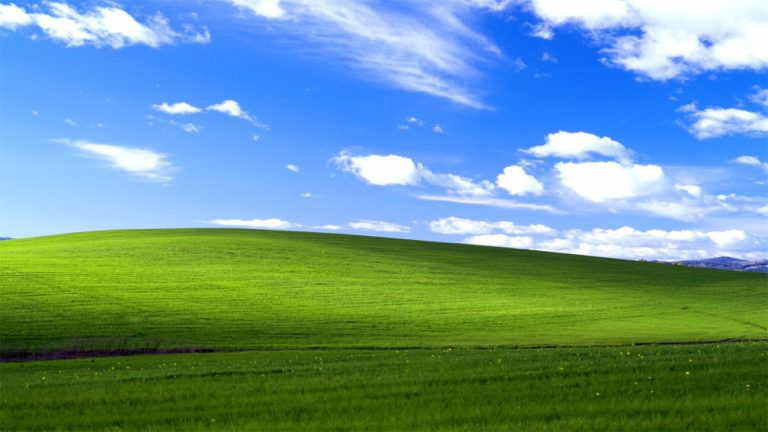

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Загружаем фото</font></b>

#@markdown *Ниже введите ссылку на фото, либо оставьте поле **source_url** пустым (в таком случае будет предложено загрузить фото с компьютера).*
source_url = 'https://opidesign.net/wp-content/uploads/landscape-architecture-fun-facts-outside-productions-blog-768x432.jpg' #@param {type:"string"}
!rm -rf $pic_name

if source_url == '':
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
  os.rename(fn, fn.replace(" ", ""))
  fn = fn.replace(" ", "")
  pic_name = "photo." + fn.split(".")[-1]
  !mv -f $fn $pic_name
else:
  try:
    pic_name = "photo." + source_url.split('.')[-1]
    !wget $source_url -O $pic_name
  except BaseException:
    print('Что-то пошло не так. Попробуйте загрузить фото с компьютера.')

image_path = '/content/photo.jpg'
image = Image.open(image_path)

clear_output()
image
#@markdown *Если при выполнении возникнет ошибка, то запустите этот блок заново*

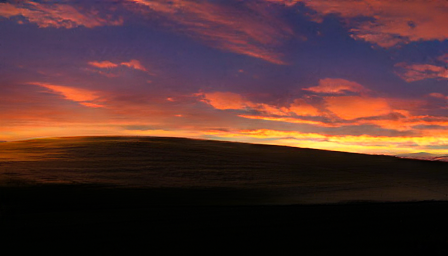

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Меняем стиль изображения</font></b> { run: "auto", display-mode: "form" }

# ----- Доступные стили -----
# print(list(styles.keys()))
# ---------------------------

#@markdown **Выберите время суток:**

#@markdown * *день* - day, hard_day, semihard_day

#@markdown * *закат* - sunset_hard_harder, presunset

#@markdown * *ночь* - 5minute, bluehour_hard, night

#@markdown * и прочие...

#@markdown ---
style = 'sunsetred' #@param ['hard_day', 'semihard_day', 'day', 'day2', 'presunset', 'sunset_hard_harder', 'sunsetred', '2minute', '5minute', '5minutes2', 'bluehour_hard', 'bluehour_bit_dark', 'night', 'night2', 'darknight', 'another_night', 'onemorenight', 'nightmore']
#@markdown ---
# Select the style, or define any vector you want
style_to_transfer = styles[style]

style_to_transfer = style_to_transfer.view(1, 1, 3, 1).to(device)
with torch.no_grad():
    content_decomposition = style_transformer.get_content(image)[0]
    decoder_input = {'content': content_decomposition['content'],
                     'intermediate_outputs': content_decomposition['intermediate_outputs'],
                     'style': style_to_transfer}
    transferred = style_transformer.trainer.gen.decode(decoder_input)['images']

clear_output()
transforms.ToPILImage()((transferred[0].cpu().clamp(-1, 1) + 1.) / 2.)

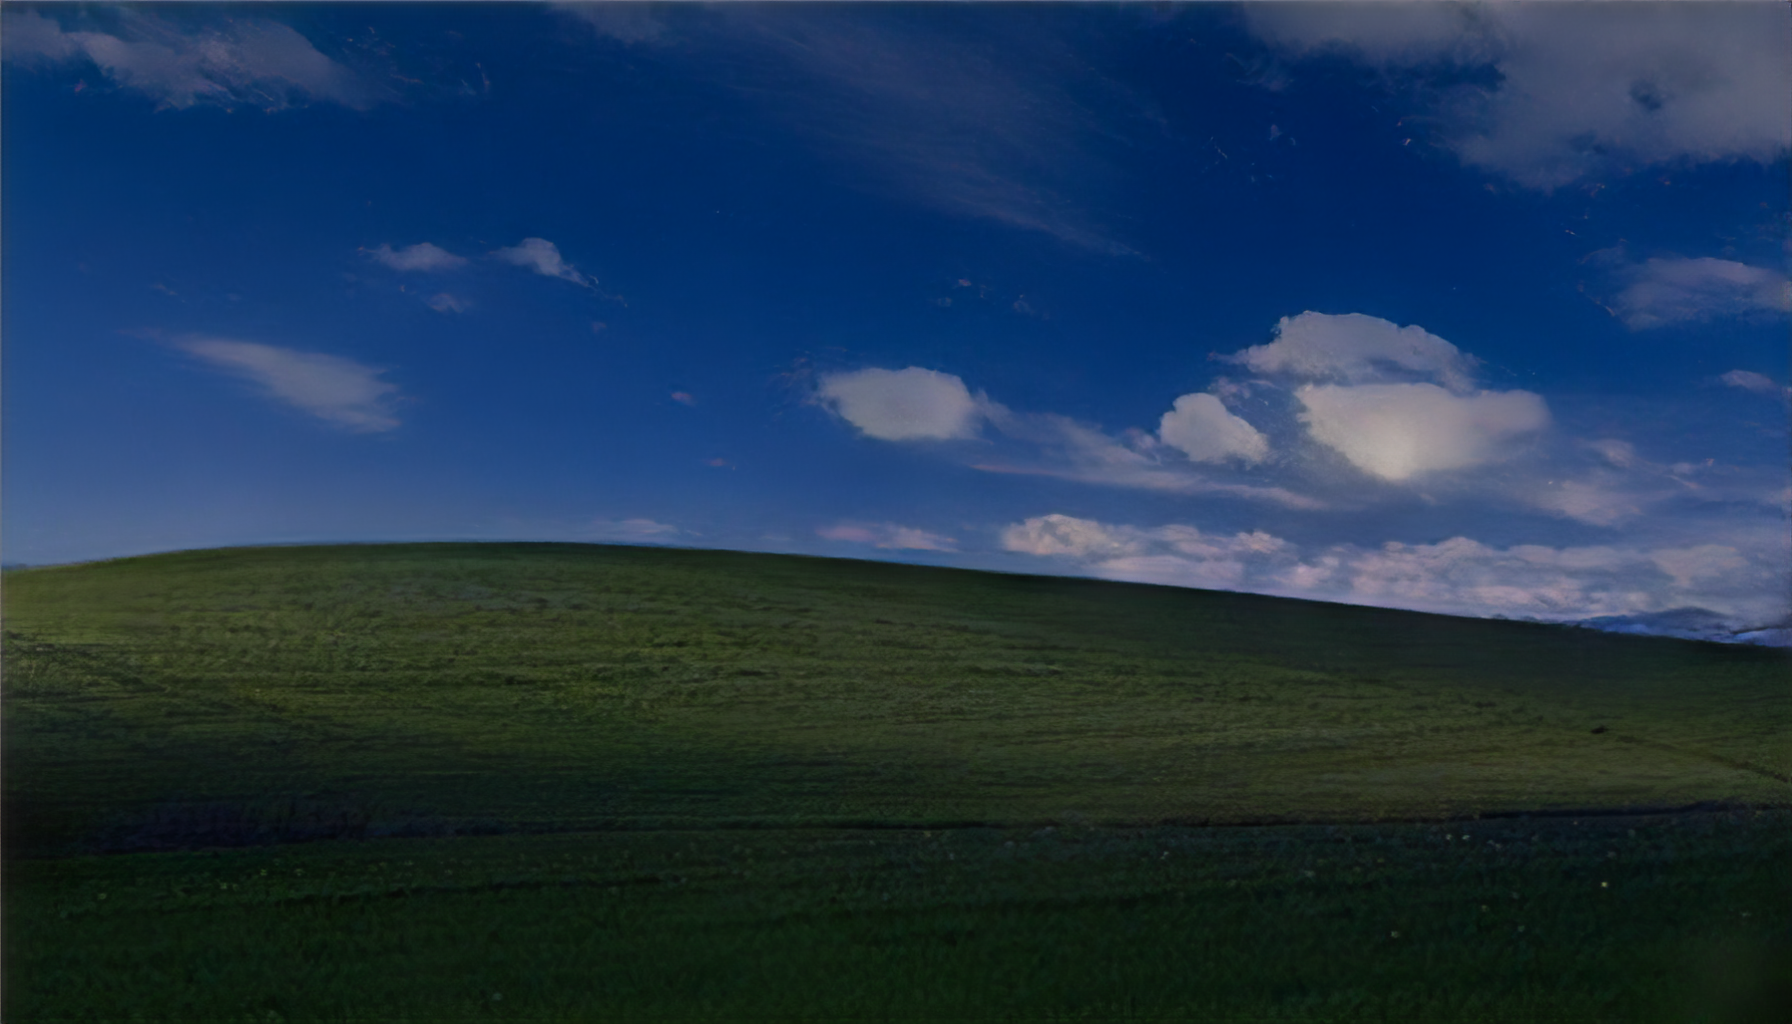

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Получить изображение в высоком разрешении</font></b>
#@markdown *Если хотите скачать изображение, ткните по нему правой кнопкой мыши и выберите "Сохранить изображение как..."*


enhancer = RRDBNet(in_nc=48, out_nc=3, nf=64, nb=5, gc=32).to(device)
enhancer.load_state_dict(torch.load(enhancer_weights))
with torch.no_grad():
    crops = [img for img in crop_transform(image)]
    content_decomposition = style_transformer.get_content(crops)[0]
    decoder_input = {'content': content_decomposition['content'],
                     'intermediate_outputs': content_decomposition['intermediate_outputs'],
                     'style': style_to_transfer.repeat(16, 1, 1, 1)}
    transferred = style_transformer.trainer.gen.decode(decoder_input)['images']
    padded_stack = enhancement_preprocessing(transferred, normalize=False)
    out = enhancer(padded_stack)

transforms.ToPILImage()((out.cpu()[0].clamp(-1, 1) + 1.) / 2.)



---

# <b><font color="black" size="+3">Обработка видео</font></b>
*↓ Нажмите, чтобы открыть раздел ↓*

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install all necessary libraries</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Установить все необходимые библиотеки</font></b>

%cd /content
!rm -rf sample_data
!rm -rf HiDT
!git clone https://github.com/saic-mdal/HiDT.git

import argparse
import glob
import os
import sys
sys.path.append('./HiDT')

import torch
from PIL import Image
from torchvision import transforms
from IPython.display import clear_output
from google.colab import files
from tqdm import tqdm

from hidt.networks.enhancement.RRDBNet_arch import RRDBNet
from hidt.style_transformer import StyleTransformer
from hidt.utils.preprocessing import GridCrop, enhancement_preprocessing

import io
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from IPython import display as ipythondisplay
from IPython.display import Image as ipythonimage
%matplotlib inline

config_path = './HiDT/configs/daytime.yaml'
gen_weights_path = './HiDT/trained_models/generator/daytime.pt'
inference_size = 256  # the network has been trained to do inference in 256px, any higher value might lead to artifacts
device = 'cuda:0'
styles_path = './HiDT/styles.txt'
enhancer_weights = './HiDT/trained_models/enhancer/enhancer.pth'

style_transformer = StyleTransformer(config_path,
                                     gen_weights_path,
                                     inference_size=inference_size,
                                     device=device)
with open(styles_path) as f:
    styles = f.read()
styles = {style.split(',')[0]: torch.tensor([float(el) for el in style.split(',')[1][1:-1].split(' ')]) for style in styles.split('\n')[:-1]}
crop_transform = GridCrop(4, 1, hires_size=inference_size * 4)

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload video</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загрузить видео</font></b>
uploaded = list(files.upload().keys())

if len(uploaded) > 1:
  raise ValueError('You cannot upload more than one video at a time!')

vid = uploaded[0]
os.rename(vid, vid.replace(" ", ""))
vid = vid.replace(" ", "")
vid_name = "driving." + vid.split(".")[-1]
!mv -f $vid $vid_name
vid = '/content/' + vid_name

fps_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FPS))
frames_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FRAME_COUNT))

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Split video into frames</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Порезать видео на кадры</font></b>

!rm -rf frames
!mkdir frames

frames_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FRAME_COUNT))
fps_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FPS))
vidcap = cv2.VideoCapture(vid)
success,image = vidcap.read()
count = 0
success = True
while success:
  cv2.imwrite("frames/frame%09d.jpg" % count, image)
  success,image = vidcap.read()
  count += 1

fram = os.listdir("/content/frames")
fram.sort()

fram_path = '/content/frames/' + fram[0]
first_image = Image.open(fram_path)
print("First frame:\n")
first_image

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Choose the style for the first frame video</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Выбрать стиль для видео по первому кадру</font></b>


#@markdown ---
style = '5minute' #@param ['hard_day', 'semihard_day', 'day', 'day2', 'presunset', 'sunset_hard_harder', 'sunsetred', '2minute', '5minute', '5minutes2', 'bluehour_hard', 'bluehour_bit_dark', 'night', 'night2', 'darknight', 'another_night', 'onemorenight', 'nightmore']
#@markdown ---
# Select the style, or define any vector you want
image_path = '/content/frames/' + fram[0]
image = Image.open(image_path)
style_to_transfer = styles[style]

style_to_transfer = style_to_transfer.view(1, 1, 3, 1).to(device)
with torch.no_grad():
    content_decomposition = style_transformer.get_content(image)[0]
    decoder_input = {'content': content_decomposition['content'],
                     'intermediate_outputs': content_decomposition['intermediate_outputs'],
                     'style': style_to_transfer}
    transferred = style_transformer.trainer.gen.decode(decoder_input)['images']

clear_output()
transforms.ToPILImage()((transferred[0].cpu().clamp(-1, 1) + 1.) / 2.)

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Change the video style</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Изменить стиль видео</font></b>
%%time
!rm -rf stylized_frames
!mkdir stylized_frames

count = 0
for i in fram:
  count += 1
  image_path = '/content/frames/' + i
  image = Image.open(image_path)

  style_to_transfer = styles[style]
  style_to_transfer = style_to_transfer.view(1, 1, 3, 1).to(device)
  with torch.no_grad():
      content_decomposition = style_transformer.get_content(image)[0]
      decoder_input = {'content': content_decomposition['content'],
                      'intermediate_outputs': content_decomposition['intermediate_outputs'],
                      'style': style_to_transfer}
      transferred = style_transformer.trainer.gen.decode(decoder_input)['images']

  transforms.ToPILImage()((transferred[0].cpu().clamp(-1, 1) + 1.) / 2.)
  result = transforms.ToPILImage()((transferred[0].cpu().clamp(-1, 1) + 1.) / 2.)
  result.save('/content/stylized_frames/stylized_' + i.split('.')[0] + '.png')
  clear_output()
  print('Осталось обработать кадров: {}'.format(len(fram)-count))

clear_output()

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Join frames in a video</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Собрать кадры в видео</font></b>
!rm -rf stylized_video.mp4
!rm -rf sound.mp3

!ffmpeg -y -i $vid -vn -ar 44100 -ac 2 -ab 192K -f mp3 sound.mp3
staffs = []
img = os.listdir("/content/stylized_frames")
img.sort()
for i in img:
  staffs.append("/content/stylized_frames/"+i)

staff = cv2.imread(staffs[0])  # get size from the 1st frame
writer = cv2.VideoWriter(
    'stylized_video.mp4',
    cv2.VideoWriter_fourcc(*'MP4V'),   # codec (*'DIVX', *'MP4V', *'FMP4', *'MJPG', *'XVID', *'MP4S')
    fps_of_video,  # fps
    (staff.shape[1], staff.shape[0]),  # width, height
    isColor=len(staff.shape) > 2)
for staff in map(cv2.imread, staffs):
    writer.write(staff)
writer.release()

dstvid = 'stylized_video.mp4'
tmpfile = dstvid.replace('.mp4', '-audio.mp4')
!ffmpeg -i sound.mp3 -i $dstvid $tmpfile
!rm -rf $dstvid
!mv -f $tmpfile $dstvid
clear_output()

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Open the final video</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Открыть финальное видео</font></b>
display(mpy.ipython_display("/content/stylized_video.mp4", height=400, autoplay=1, loop=1, maxduration=600))

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Download the final video</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Скачать финальное видео</font></b>
files.download('/content/stylized_video.mp4')